<h2 align="center">BERT tutorial: Classify spam vs no spam emails</h2>

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

<h4>Import the dataset (Dataset is taken from kaggle)</h4>

In [ ]:
import pandas as pd

df = pd.read_csv("spam.csv")
df.head(5)

,Category,Message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [ ]:
df.groupby('Category').describe()

Message                                                            \
           count unique                                                top   
Category                                                                     
ham         4825   4516                             Sorry, I'll call later   
spam         747    641  Please call our customer service representativ...   

               
         freq  
Category       
ham        30  
spam        4

In [ ]:
df['spam']=df['Category'].apply(lambda x: 1 if x=='spam' else 0)
df.head()

,Category,Message,spam
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


<h4>Split it into training and test data set</h4>

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df['Message'],df['spam'], stratify=df['spam'])

In [ ]:
X_train.head(4)

4870    1. Tension face 2. Smiling face 3. Waste face ...
1281    Oh ho. Is this the first time u use these type...
1666    Dunno cos i was v late n when i reach they ins...
1254    Mum say we wan to go then go... Then she can s...
Name: Message, dtype: object

<h4>Now lets import BERT model and get embeding vectors for few sample statements</h4>

In [ ]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

In [ ]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

get_sentence_embeding([
    "500$ discount. hurry up",
    "Bhavin, are you up for a volleybal game tomorrow?"]
)

<tf.Tensor: shape=(2, 768), dtype=float32, numpy=
array([[-0.8435169 , -0.51327276, -0.8884574 , ..., -0.74748874,
        -0.75314736,  0.91964483],
       [-0.87208366, -0.50543964, -0.94446677, ..., -0.858475  ,
        -0.7174535 ,  0.8808298 ]], dtype=float32)>

<h4>Get embeding vectors for few sample words. Compare them using cosine similarity</h4>

In [ ]:
e = get_sentence_embeding([
    "banana",
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.9911089]], dtype=float32)

Values near to 1 means they are similar. 0 means they are very different.
Above you can use comparing "banana" vs "grapes" you get 0.99 similarity as they both are fruits

In [ ]:
cosine_similarity([e[0]],[e[3]])

array([[0.8470385]], dtype=float32)

Comparing banana with jeff bezos you still get 0.84 but it is not as close as 0.99 that we got with grapes

In [ ]:
cosine_similarity([e[3]],[e[4]])

array([[0.98720354]], dtype=float32)

Jeff bezos and Elon musk are more similar then Jeff bezos and banana as indicated above

<h4>Build Model</h4>

There are two types of models you can build in tensorflow.

(1) Sequential
(2) Functional

So far we have built sequential model. But below we will build functional model. More information on these two is here: https://becominghuman.ai/sequential-vs-functional-model-in-keras-20684f766057

In [ ]:
# Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

# Neural network layers
l = tf.keras.layers.Dropout(0.1, name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(l)

# Use inputs and outputs to construct a final model
model = tf.keras.Model(inputs=[text_input], outputs = [l])

https://stackoverflow.com/questions/47605558/importerror-failed-to-import-pydot-you-must-install-pydot-and-graphviz-for-py

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
text (InputLayer)               [(None,)]            0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        {'input_mask': (None 0           text[0][0]                       
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      {'default': (None, 7 109482241   keras_layer[0][0]                
                                                                 keras_layer[0][1]                
                                                                 keras_layer[0][2]                
______________________________________________________________________________________________

In [ ]:
len(X_train)

4179

In [ ]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

<h4>Train the model</h4>

In [ ]:
model.fit(X_train, y_train, epochs=5)

Epoch 1/5
131/131 [==============================] - 31s 188ms/step - loss: 0.3172 - accuracy: 0.8686
Epoch 2/5
131/131 [==============================] - 26s 197ms/step - loss: 0.2286 - accuracy: 0.8995
Epoch 3/5
131/131 [==============================] - 26s 199ms/step - loss: 0.1925 - accuracy: 0.9244
Epoch 4/5
131/131 [==============================] - 27s 204ms/step - loss: 0.1703 - accuracy: 0.9354
Epoch 5/5
131/131 [==============================] - 25s 189ms/step - loss: 0.1550 - accuracy: 0.9457


In [ ]:
model.evaluate(X_test, y_test)

44/44 [==============================] - 9s 187ms/step - loss: 0.1490 - accuracy: 0.9476


[0.1490102857351303, 0.9475951194763184]

<h4>Inference</h4>

In [ ]:
reviews = [
    'Reply to win Â£100 weekly! Where will the 2006 FIFA World Cup be held? Send STOP to 87239 to end service',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.5297462 ],
       [0.58646685],
       [0.40190795],
       [0.03496679],
       [0.01311444]], dtype=float32)

In [ ]:
model.save("saved_models/1/")

INFO:tensorflow:Assets written to: saved_models/1/assets


INFO:tensorflow:Assets written to: saved_models/1/assets


In [ ]:
model.save("saved_models/2/")

INFO:tensorflow:Assets written to: saved_models/2/assets


INFO:tensorflow:Assets written to: saved_models/2/assets


In [ ]:
model.save("saved_models/3/")

INFO:tensorflow:Assets written to: saved_models/3/assets


INFO:tensorflow:Assets written to: saved_models/3/assets


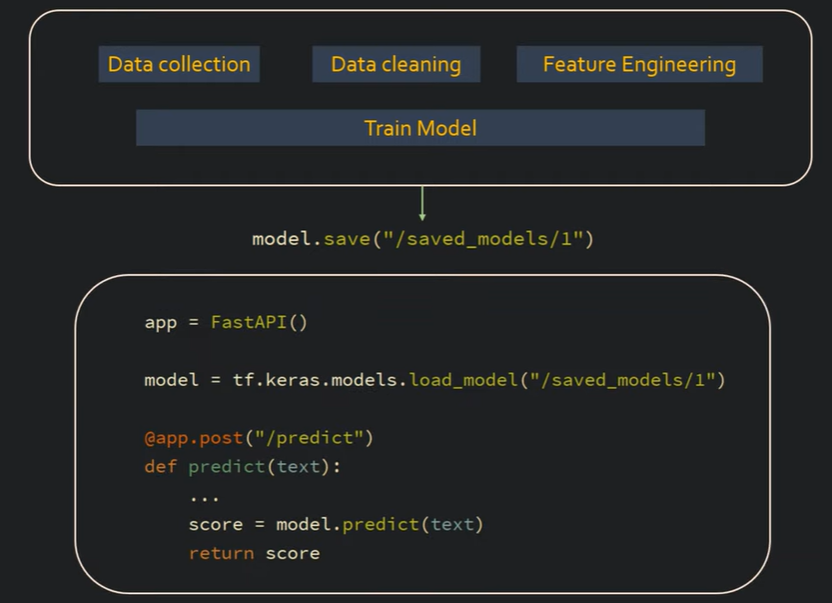

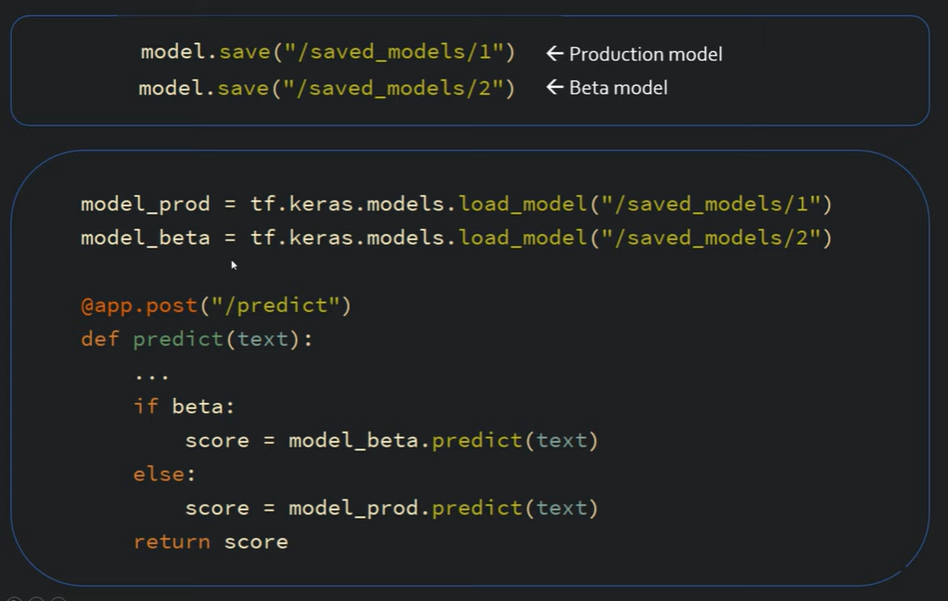

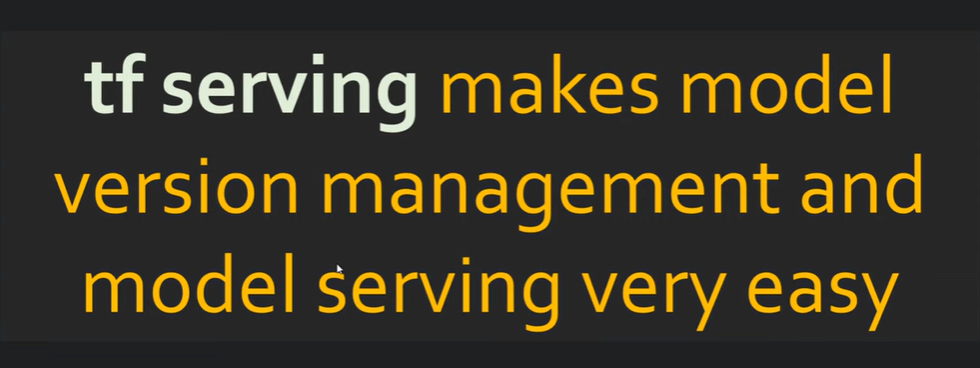

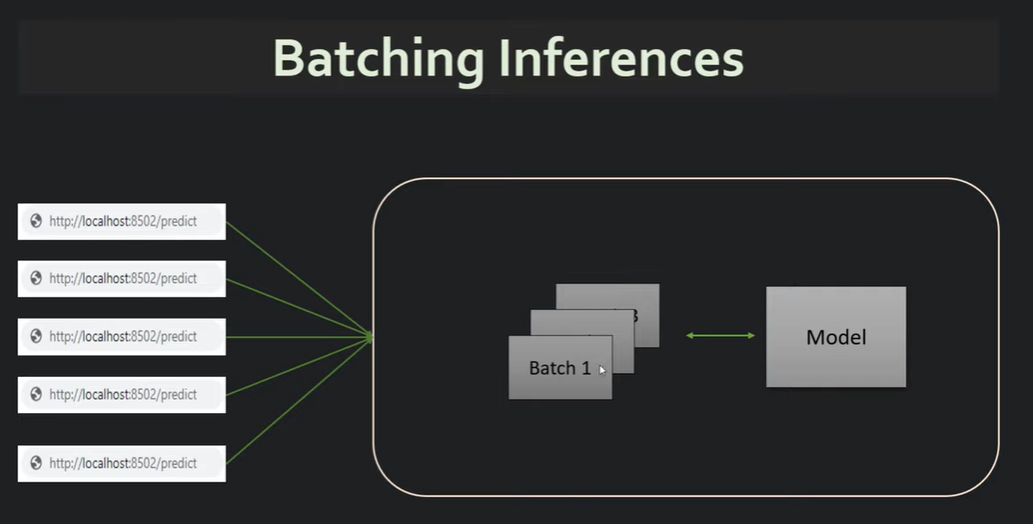